# Unsupervised learning - Customer Segmentation

Wholesale Customers Data Set (click [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv) to download)

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

Description: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers#

Why is the customer segmentation needed?

- to understand customer preferences
- to address the requirements of each and every individual customer
- to find the mosth valuable segments (maximum profit)
- to optimize marketing techniques


## Content:
* [Data exploration](#eda)
* [Data preparation](#prep)
* [Clustering](#clustering)

## Data exploration <a class="anchor" id="eda"></a>

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Go through the data to gain necessary insights about it:

In [50]:
try:
    data = pd.read_csv('Wholesale customers data.csv')
    print("The dataset has {} observations with {} features".format(*data.shape))
except:
    print("Error when reading the file")


The dataset has 440 observations with 8 features


In [51]:
data.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.5 KB


In [53]:
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Check missing values:

In [54]:
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Create a barplot and a piechart to view the Region and Channel distribution across our customer data.

C:\Users\ORDI\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


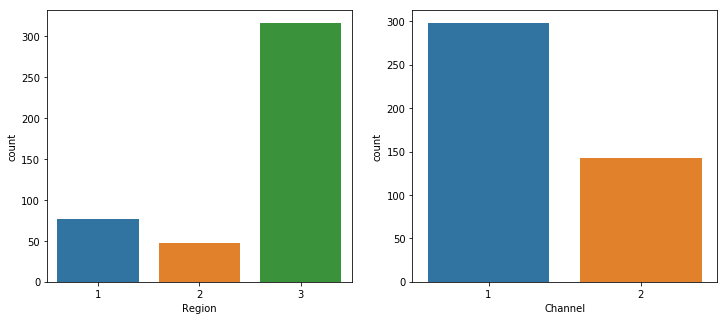

In [55]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.countplot(data['Region'], ax=ax[0])
sns.countplot(data['Channel'], ax=ax[1])
fig.show()



C:\Users\ORDI\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


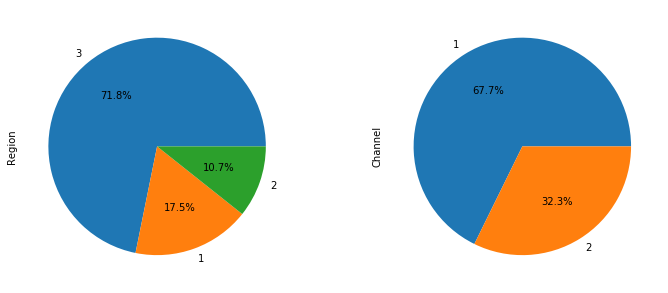

In [56]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
data['Region'].value_counts().plot(kind='pie',autopct='%1.1f%%', ax=ax[0])
data['Channel'].value_counts().plot(kind='pie',autopct='%1.1f%%', ax=ax[1])
fig.show()

From the charts above, we observe that Region 1 (Lisnon) and Region 2 (Oporto) are presented in the data less then Region 3 (Other).  

The percentage of Channel 1 (Horeca, i.e. Hotel/Restaurant/Cafe) is higher than Channel 2 (Retail)



For better understanding of the data set, we will produce a scatter matrix for each pair of features in the data:

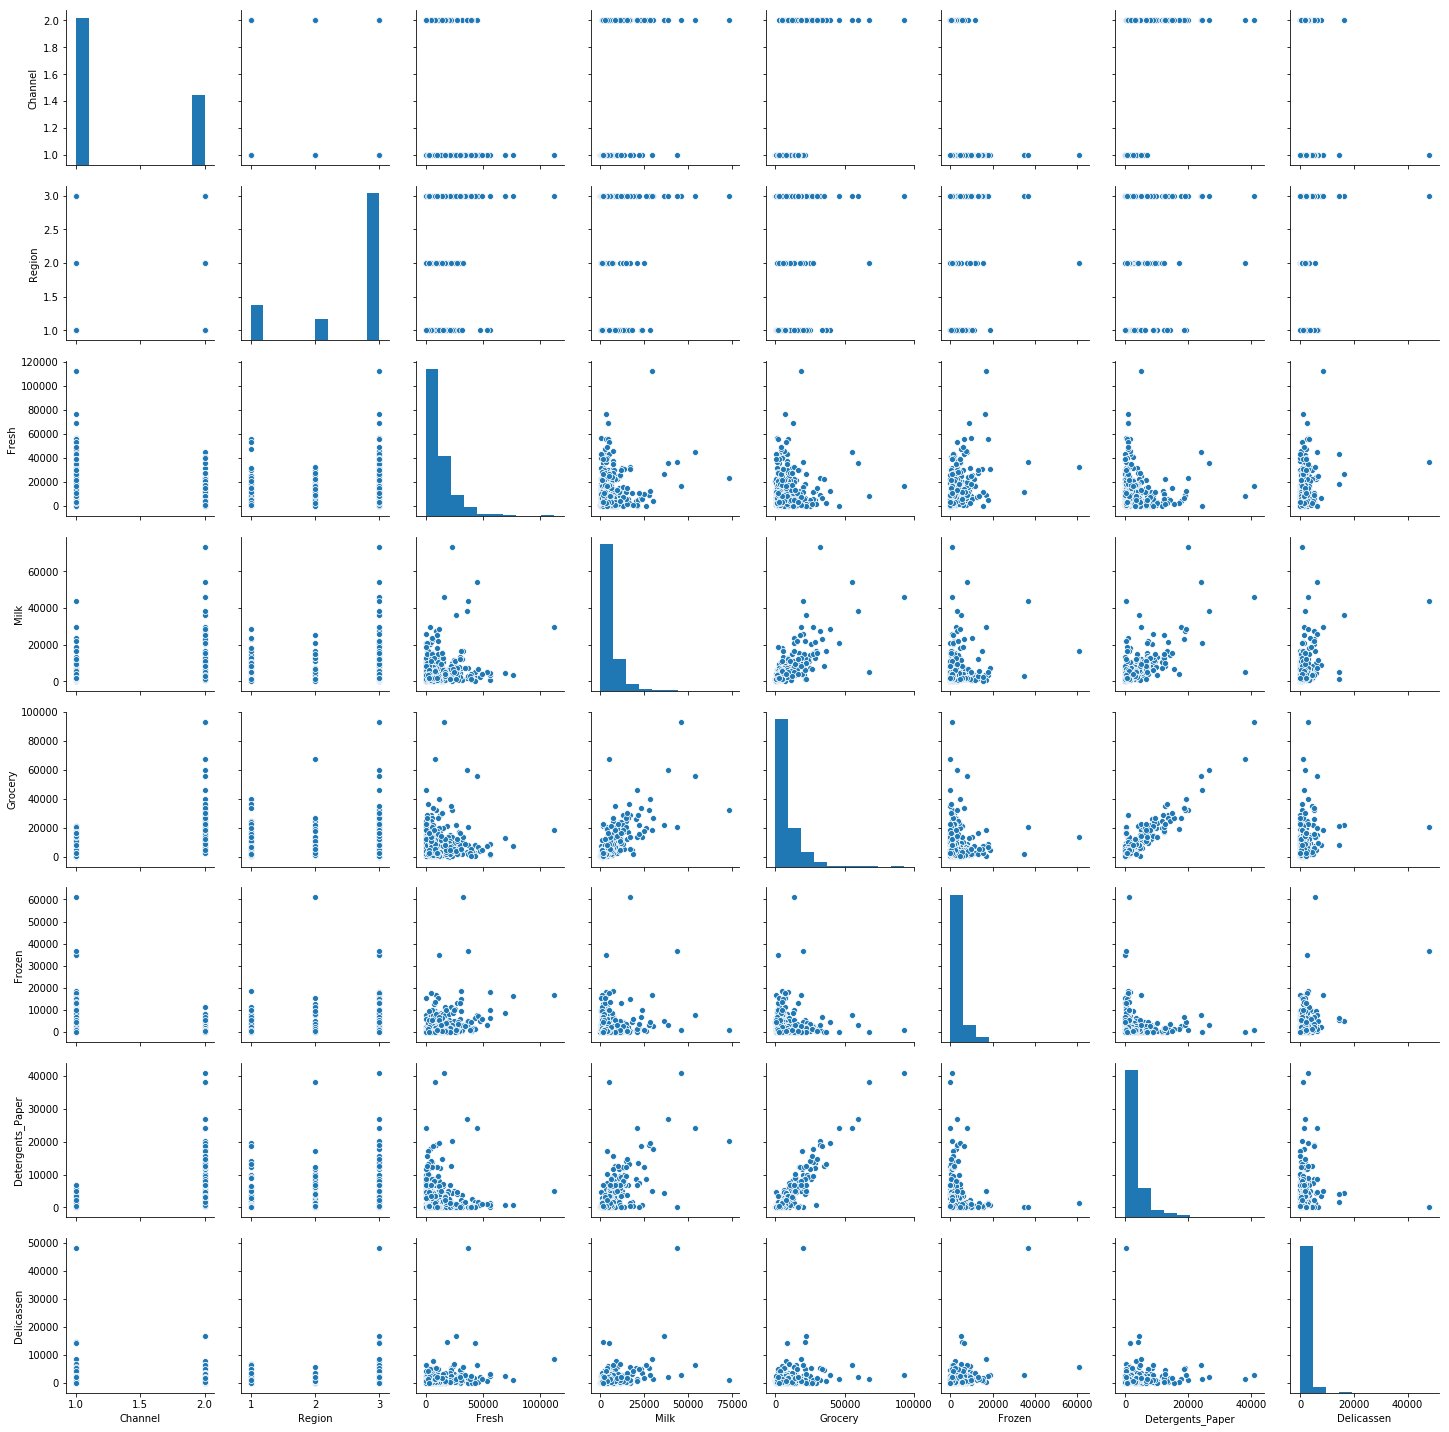

In [57]:
sns.pairplot(data)

The scatter plot shows some linear trends which indicates that there might be correlations between Grocery and Detergents_Paper, Grocery and Milk, Milk and Detergents_Paper

Build the Correlation Matrix:

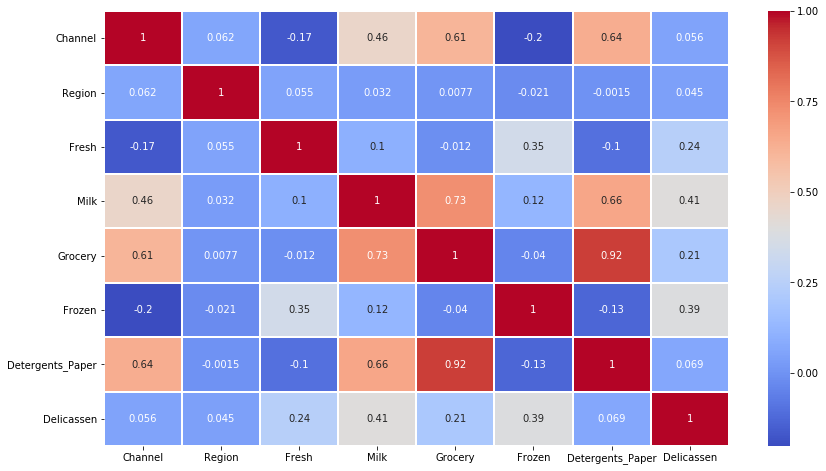

In [58]:
plt.figure(figsize=(14,8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", linecolor="white", linewidth=1)

5 pairs of features exhibit some degree of correlation:
- Grocery and Detergents_Paper 
- Grocery and Milk
- Milk and Detergents_Paper
- Channel and Detergents_Paper
- Channel and Grocery


K-means clustering works only with numerical data (taking the mean of categorical data doesn't make any sense as well as calculating the distance). <br> To work with nominal variables, we would need to define the degree-of-difference between Region anf Channel values. To keep things simple, we will proceed with continuous real-valued numbers.<br>
Gaussian distributions are defined only on continuous variables too.
So the features 'Channel' and 'Region' will be excluded from the analyses. Instead we will focus on the 6 product features.

Besides, Grocery doesn't look as an informative feature. As shown above, it is strongly correlated with Detergents_Paper and Milk, so this feature might be excluded from analysing customers' spending habits too. 
TODO: how much will the Grocery column affect the clustering solution?

Explore the product features thoroughly and build box plots to detect outliers:

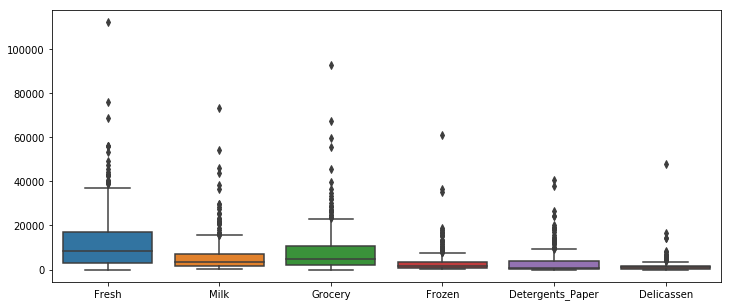

In [59]:
product_spending_cols = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
product_data = data[product_spending_cols]
plt.figure(figsize=(12,5))
sns.boxplot(data=product_data)

The data has a lot of outlying points, but they don't look like incorrect values. We are not sure that those huge annual spendings are not representative of customers. So we will not delete them from analysis. 

Proceed to examine the data using a density plot:

FRESH: Skewness is 2.561322751927935; Kurtosis is 11.536408493056006
MILK: Skewness is 4.053754849210881; Kurtosis is 24.669397750673077
GROCERY: Skewness is 3.5874286903915453; Kurtosis is 20.914670390919653
FROZEN: Skewness is 5.9079856924559575; Kurtosis is 54.68928069737255
DETERGENTS_PAPER: Skewness is 3.6318506306913645; Kurtosis is 19.009464335418212
DELICASSEN: Skewness is 11.151586478906117; Kurtosis is 170.69493933454066


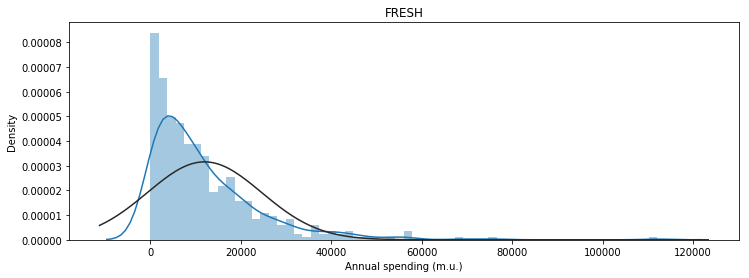

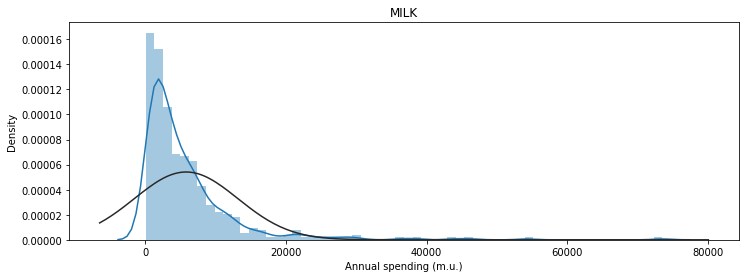

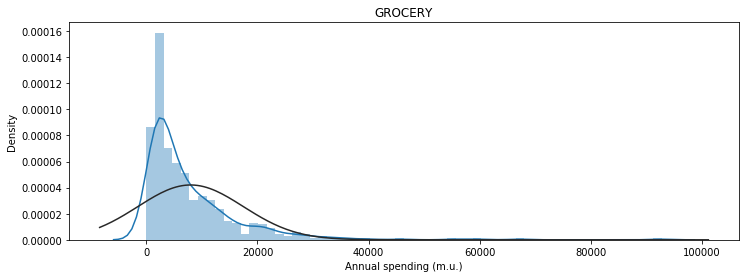

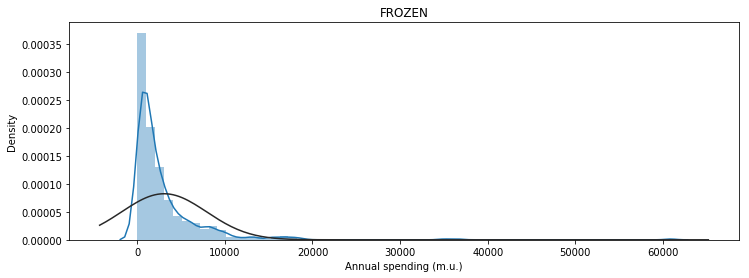

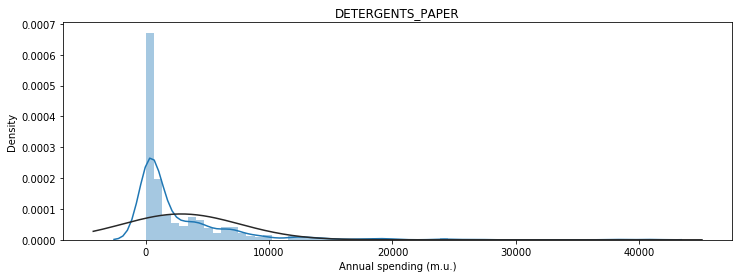

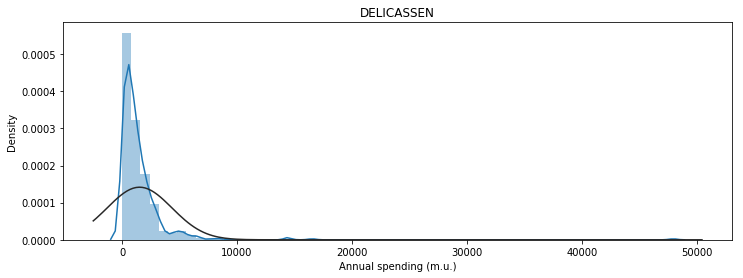

In [60]:
for column in product_spending_cols:
    plt.figure(figsize=(12,4))
    title = column.upper()
    plt.title(title)   
    plt.xlabel('Annual spending (m.u.)')
    plt.ylabel('Density')
    sns.distplot(data[column], bins=60, fit=norm, axlabel=False)
    skewness = data[column].skew()
    kurt = data[column].kurt()
    print(f'{title}: Skewness is {skewness}; Kurtosis is {kurt}')


## Data Preparation<a class="anchor" id="prep"></a>

In the Kernel Density Plots displayed above, we observe that the variables don't have a normal distribution.

Skewness values > 1 => data is highly skewed<br>
Kurtosis >> 3 indicating that the distributions are heavy-tailed and have large amount of outliers

The next steps are:
- Unskew the data - apply log transformation
- Standardize/Scale to the same mean and standard deviation



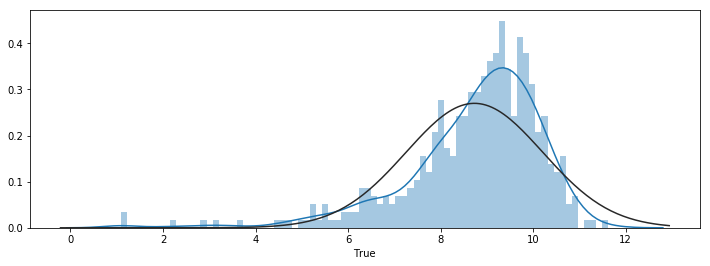

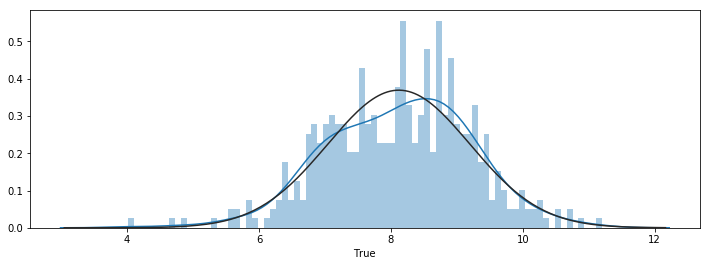

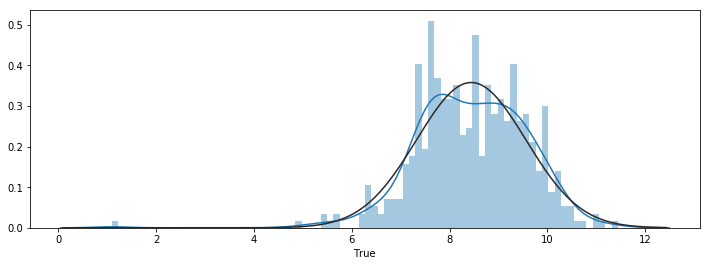

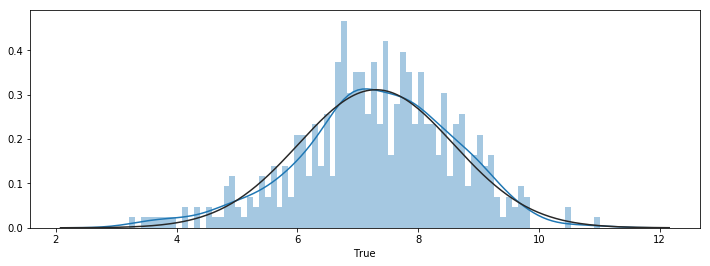

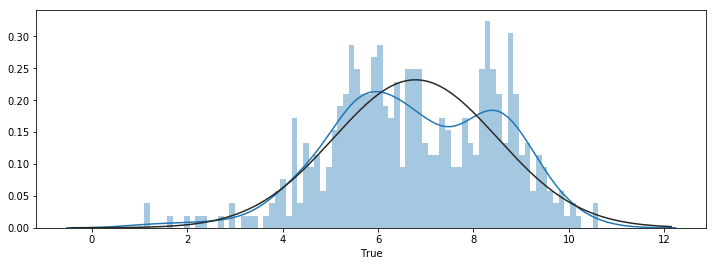

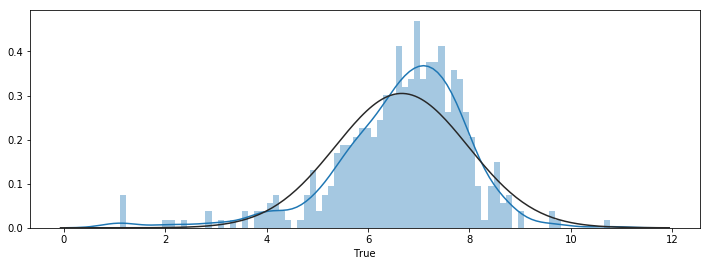

In [61]:
# Apply Log transformations to manage skewness

log_data = np.log(product_data)
for column in log_data.columns:
    plt.figure(figsize=(12,4))
    sns.distplot(log_data[column], bins=80, fit=norm, axlabel=True)

After applying a natural logarithm scaling to the data, the distribution of each feature appears much more normal. 
Check whether the correlations between the features are still present:

C:\Users\ORDI\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


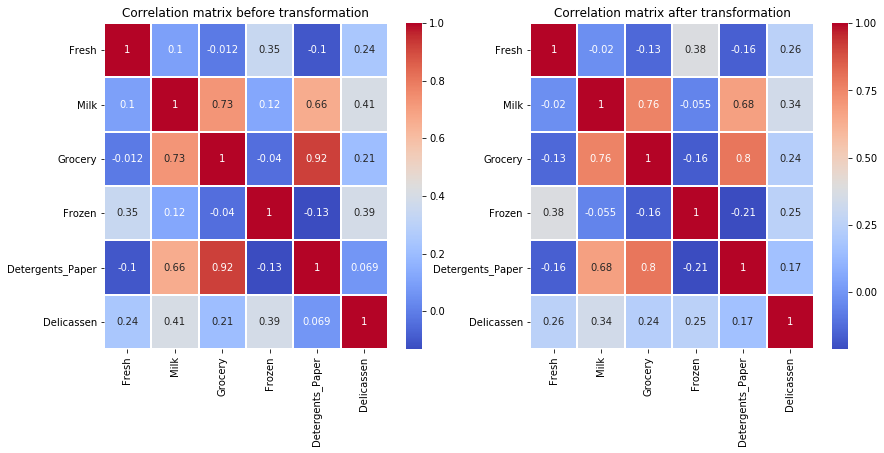

In [62]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].set_title('Correlation matrix before transformation')
sns.heatmap(data[product_spending_cols].corr(), annot=True, cmap="coolwarm", linecolor="white", linewidth=1,  ax=ax[0])
ax[1].set_title('Correlation matrix after transformation')
sns.heatmap(log_data.corr(), annot=True, cmap="coolwarm", linecolor="white", linewidth=1, ax=ax[1])
fig.show()



Now Grocery and Detergents_Paper have a weaker correlation.<br>
Grocery and Milk has a slightly stronger correlation.<br>
Detergents_Paper and Milk has a slightly stronger correlation too.

NB: check if features should be first standardized before clustering?

From "The Elements of Statistical Learning":
<blockquote>Although this may seem reasonable, and is often recommended, it can be highly counterproductive. If the goal is to
segment the data into groups of similar objects, all attributes may not contribute equally to the (problem-dependent) notion of dissimilarity between objects. If the goal is to discover natural groupings in the data, some attributes may exhibit more of a grouping tendency than others. Variables that are more relevant in separating the groups should be assigned a higher influence in defining object dissimilarity. Giving all attributes equal influence in this case will tend to obscure the groups to the point where a clustering algorithm cannot uncover them.</blockquote>

In [63]:
# Normalize the variables with StandardScaler
scaler = StandardScaler()
scaler.fit(log_data)
features_scaled = scaler.transform(log_data)
data_scaled = pd.DataFrame(features_scaled, index=data.index, columns=product_spending_cols)
data_scaled.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-1.862147e-16,-3.691492e-16,-2.556036e-16,1.826822e-16,1.396610e-16,6.550316e-16
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-5.162332e+00,-3.808515e+00,-6.585828e+00,-3.181814e+00,-3.308406e+00,-4.251391e+00
25%,-4.616414e-01,-7.277472e-01,-6.875511e-01,-5.391077e-01,-7.200844e-01,-4.989215e-01
50%,2.149246e-01,6.953960e-02,2.322023e-02,2.259570e-02,-4.709210e-02,1.584857e-01
75%,6.808223e-01,7.030903e-01,7.468678e-01,6.815637e-01,8.658021e-01,6.427625e-01
max,1.959605e+00,2.855165e+00,2.687964e+00,2.895443e+00,2.228613e+00,3.140996e+00


Now all the features have a zero mean and a single unit variance. <br>
Before applying the K-means clustering algorithm we will find principal components. PCA will help us visualize high dimensional data

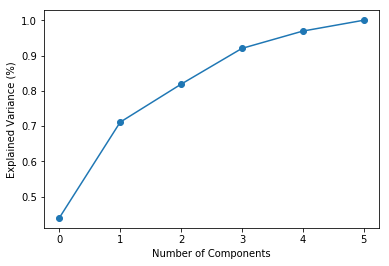

In [64]:
n_components = len(product_spending_cols)
pca = PCA(n_components=n_components)
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (%)') 
plt.show()


The first 2 principal components explain > 80% variance, so will apply PCA by fitting the data with 2 dimensions:

In [65]:
pca = PCA(n_components=2)
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)
# Create a new DataFrame for the reduced data
data_pca = pd.DataFrame(data_pca, columns = ['Dimension 1', 'Dimension 2'])

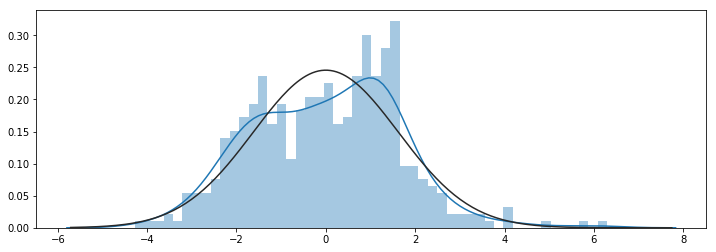

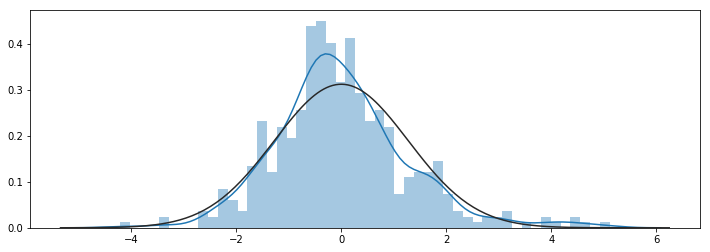

In [66]:
for column in data_pca.columns:
    plt.figure(figsize=(12,4))    
    sns.distplot(data_pca[column], bins=50, fit=norm, axlabel=False)

## Clustering <a class="anchor" id="clustering"></a>

Firstly, we will use K-Means algorithm.<br>
It is one of the popular methods of clustering unlabelled data into k clusters.
To select the optimal number of clusters we will calculate inertia (the sum of squared distance for each point to it's closest centroid, i.e. its assigned cluster) and use the Elbow method:


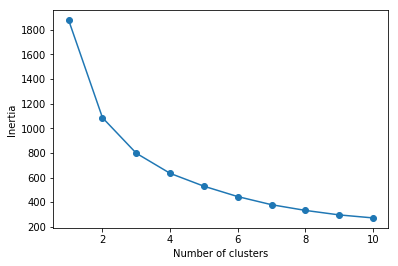

In [67]:
max_n_clusters = 10
inertias = []
n_clusters = list(range(1,max_n_clusters+1))

for k in n_clusters:
    kmm = KMeans(n_clusters=k, init='k-means++', n_init=20).fit(data_pca)
    predictions = kmm.predict(data_pca)
    centers = kmm.cluster_centers_
    inertias.append(kmm.inertia_)

plt.plot(range(1, max_n_clusters+1), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Since the Elbow method doesn't provide the exact answer (2, 3 or 4 clusters?), we will also check the Silhouette method:

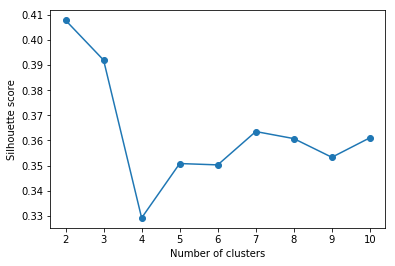

In [68]:
silhouette_scores = []
n_clusters = list(range(2,max_n_clusters+1))

for k in n_clusters:
    kmm = KMeans(n_clusters=k, init='k-means++', n_init=20).fit(data_pca)
    predictions = kmm.predict(data_pca)   
    score = silhouette_score(data_pca, predictions, metric='euclidean')
    silhouette_scores.append(score) 

plt.plot(range(2, max_n_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


In [69]:
# Min number of clusters for the Silhouette Coefficient calculation is 2, shift the array index 
best_number_of_clusters = np.argmax(silhouette_scores) + 2
print('The optimal number of clusters K = {}. The Average Silhouette score takes on its max value {:.2f}'.format(best_number_of_clusters, max(silhouette_scores)))

The optimal number of clusters K = 2. The Average Silhouette score takes on its max value 0.41


Though K-Means clustering is efficient and simple algorithm, a Gaussian mixture model very often fits better than K-means: the clustering mimics the data cloud better and with a smaller K.

In [70]:
n_clusters = list(range(2,11))

for k in n_clusters:
    gmm = GaussianMixture(n_components=k).fit(data_pca)
    predictions = gmm.predict(data_pca)
    score = silhouette_score(data_pca, predictions, metric='mahalanobis')
    print("For the number of clustres K = {}, the average silhouette score = {}".format(k, score))

For the number of clustres K = 2, the average silhouette score = 0.36864834784188677
For the number of clustres K = 3, the average silhouette score = 0.3334082245018834
For the number of clustres K = 4, the average silhouette score = 0.3135329135282084
For the number of clustres K = 5, the average silhouette score = 0.22139469759779684
For the number of clustres K = 6, the average silhouette score = 0.2959083151081227
For the number of clustres K = 7, the average silhouette score = 0.27940674713498764
For the number of clustres K = 8, the average silhouette score = 0.30376733290779767
For the number of clustres K = 9, the average silhouette score = 0.31266773086996447
For the number of clustres K = 10, the average silhouette score = 0.31219561467772083


The Gaussina Mixture model also gives 2 clusters as the optimal number

In [71]:
gmm = GaussianMixture(n_components=best_number_of_clusters).fit(data_pca)
predictions = gmm.predict(data_pca)
centers = gmm.means_
data_pca["Customer Segment"] = predictions


In [72]:
data_pca.head()


,Dimension 1,Dimension 2,Customer Segment
0,-1.379375,0.303838,1
1,-1.434807,-0.538147,1
2,-1.503951,-1.226153,1
3,0.824133,-1.205770,0
4,-0.797388,-1.756986,0


Text(0, 0.5, 'Dimension 2')

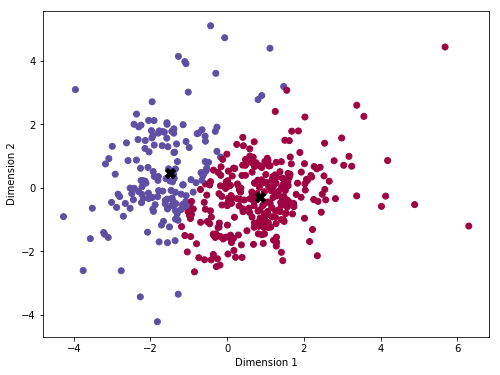

In [73]:
plt.figure(figsize=(8,6))
plt.scatter(data_pca["Dimension 1"], data_pca["Dimension 2"], c=data_pca["Customer Segment"], cmap='Spectral')
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, marker='X')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

Restore the original customer spendings by applying the inverse transformations.

In [74]:
# Inverse transform the centers
centers_pca_inversed = pca.inverse_transform(centers)
centers_scaler_inversed = scaler.inverse_transform(centers_pca_inversed)
centers_restored = np.exp(centers_scaler_inversed)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(1,len(centers)+1)]
centers_restored = pd.DataFrame(np.round(centers_restored), columns = product_spending_cols)
centers_restored.index = segments
display(centers_restored)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 1,8993.0,2118.0,2677.0,2127.0,380.0,749.0
Segment 2,3229.0,7529.0,12043.0,791.0,3858.0,851.0


We may conclude that a customer belongs to <b>Segment 1</b> if their spendings on "Fresh" and "Frozen" are high and spendings on "Milk", "Grocery", "Detergents_Paper" are much lower<br>
A customer belongs to <b>Segment 2</b> if their spendings on "Milk", "Grocery" And "Detergents_Paper" are high.

Segment 1 may represent retailers specialising on fresh and frozen food and Segment 2 may represet cafes. 
<br>These 2 segments match the Channel variable (Horeca, i.e. Hotel/Restaurant/Cafe and Retail))


In [75]:
data_pca_with_channels = data_pca.copy()
data_pca_with_channels['Channel'] = data['Channel']

Text(0, 0.5, 'Second Principal Component')

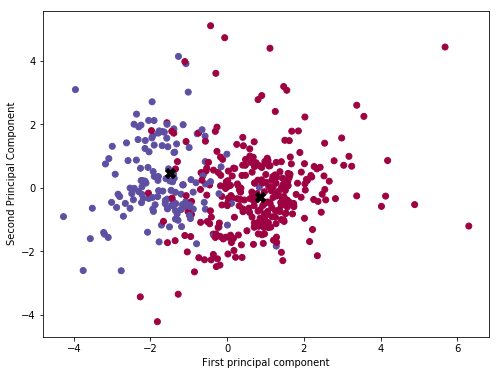

In [76]:
plt.figure(figsize=(8,6))
plt.scatter(data_pca_with_channels["Dimension 1"], data_pca_with_channels["Dimension 2"], c=data_pca_with_channels["Channel"], cmap='Spectral')
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, marker='X')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')